##  <u> *Data Modelling*  </u>

In [ ]:
%run 3_EDA.ipynb

---

### <u>*Regression Modelling for Frequency as a Target Features*</u>


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor,XGBRFRegressor
import warnings
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from hyperopt import fmin,tpe,STATUS_OK,Trials,hp


---

### *A.* <u>*Frequency as a Target Feature :*</u>

#### *A.1*<br> <u>*Basic Models Comparison :*</u>

##### *A.1.1*<br> <u>*Models :*</u>

In [3]:
models = {
                "Random Forest": RandomForestRegressor(random_state=41),
                "Decision Tree": DecisionTreeRegressor(random_state=41),
                "Gradient Boosting": GradientBoostingRegressor(random_state=41),
                "XGBRFRegressor":XGBRFRegressor(random_state=41),
                "CatBoosting Regressor": CatBoostRegressor(verbose=False,random_state=41),
                "AdaBoost Regressor": AdaBoostRegressor(random_state=41),
            }

##### *A.1.2*<br> <u>*Prepare Date :*</u>

In [4]:
df3=df.copy()
df3.drop(["clm"],axis=1,inplace=True)

In [5]:
x_frequincy=df3.drop("frequincy",axis=1)
y_frequincy=df3["frequincy"]

xtrain_full,xtest_full, ytrain, ytest = train_test_split(x_frequincy, y_frequincy, train_size=0.8, test_size=0.2,random_state=0)

numerical_cols = [col for col in xtrain_full.columns if xtrain_full[col].dtype in ['int64', 'float64']]
categorical_cols =[col for col in xtrain_full.columns if  xtrain_full[col].dtype == "object"]

my_cols = categorical_cols + numerical_cols
xtrain = xtrain_full[my_cols].copy()
xtest = xtest_full[my_cols].copy()

numerical_transformer = Pipeline(steps=[
    ("scaler",StandardScaler())
    ])


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ("scaler",StandardScaler(with_mean=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

##### *A.1.3*<br> <u>*Apply Models :*</u>

In [7]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square


model_list = []
r2_list =[]
mae_list=[]
rmse_list=[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model =my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('melbourne_model', model)
        
                             ])
    
    model.fit(xtrain, ytrain) 

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    rmse_list.append(model_test_rmse)
    mae_list.append(model_test_mae)
    
    print('='*35)
    print('\n')



Random Forest
Model performance for Training set
- Root Mean Squared Error: 0.3663
- Mean Absolute Error: 0.0045
- R2 Score: 0.9861
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.5948
- Mean Absolute Error: 0.0070
- R2 Score: 0.8755


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.5338
- Mean Absolute Error: 0.0063
- R2 Score: 0.8998


Gradient Boosting
Model performance for Training set
- Root Mean Squared Error: 0.0880
- Mean Absolute Error: 0.0125
- R2 Score: 0.9992
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4509
- Mean Absolute Error: 0.0164
- R2 Score: 0.9285


XGBRFRegressor
Model performance for Training set
- Root Mean Squared Error: 0.2105
- Mean Absolute Error: 0.0281
- R2 Score: 0.9954
--------------

##### *A.1.4*<br> <u>*Best Model :*</u>

In [8]:
pd.DataFrame(list(zip(model_list,rmse_list,mae_list,r2_list)), 
             columns=['Model Name', 'rmse_Score','mae_Score',"r2_Score"]).sort_values(by=["mae_Score"],ascending=True)

,Model Name,rmse_Score,mae_Score,r2_Score
1,Decision Tree,0.533826,0.006261,0.899755
0,Random Forest,0.594834,0.006987,0.875533
4,CatBoosting Regressor,0.417351,0.008232,0.938727
2,Gradient Boosting,0.450858,0.016407,0.928494
3,XGBRFRegressor,0.315303,0.029334,0.965028
5,AdaBoost Regressor,0.873198,0.147845,0.731781


##### *A.1.5*<br> <u>*Apply Best Model :*</u>

In [9]:
XGBRFRegressor_model = XGBRegressor()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('melbourne_model', XGBRFRegressor_model)# or ('melbourne_model', RandomForestRegressor(random_state=0,n_estimators=50)) 
                             ])
my_pipeline.fit(xtrain, ytrain)
preds = my_pipeline.predict(xtest)
score = mean_absolute_error(ytest, preds)
print('MAE:', score)
score = r2_score(ytest, preds)*100
print(" Accuracy of the model is %.2f" %score)

MAE: 0.005096717406139711
 Accuracy of the model is 98.25


##### *A.1.6*<br> <u>*Visualize Best Model :*</u>

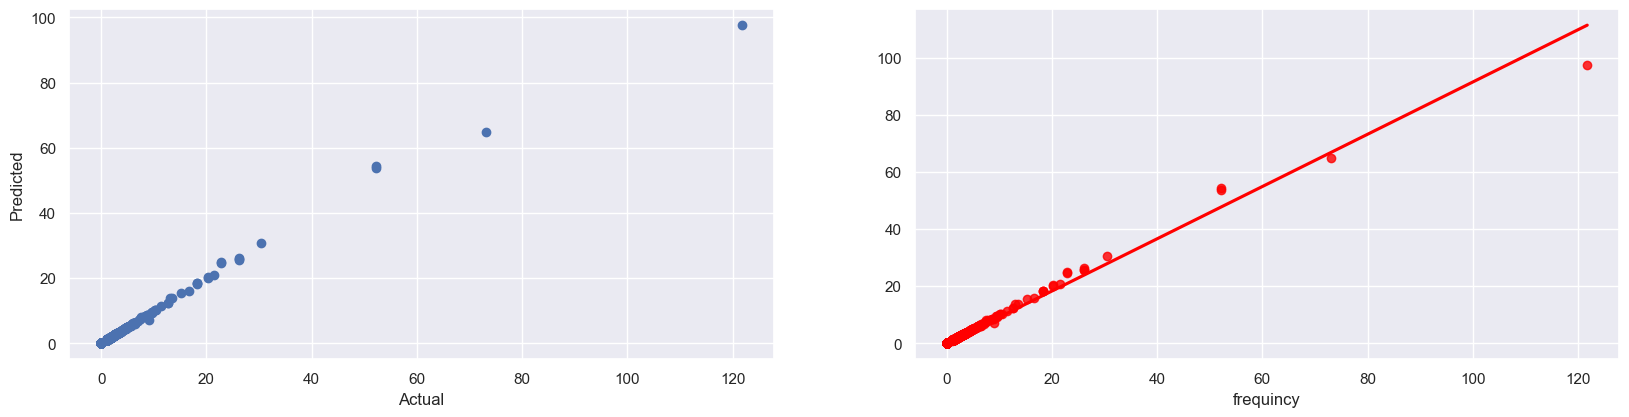

In [10]:
plt.subplot(221)
plt.scatter(ytest,preds);

plt.xlabel('Actual');
plt.ylabel('Predicted');

plt.subplot(222)
sns.regplot(x=ytest,y=preds,ci=None,color ='red');

---

#### *A.2*<br> <u>*Hyperopt Models Comparison :*</u>

##### *A.2.1*<br> <u>*Create Spaces for each model :*</u>

In [6]:
space_rf = {
    'n_estimators': hp.choice('n_estimators', range(10, 200)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }


'''space_dt = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }'''

space_XGBRFRegressor = {
  'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
  "learning_rate": hp.uniform("learning_rate", 0, 1),
  'max_depth': hp.choice("max_depth", np.arange(1,20,1)),
  "num_parallel_tree": 100,
  "subsample": hp.uniform("subsample", 0.5,1)
}

space_catboost = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'depth': hp.choice('depth', range(1, 12)),
    'iterations': hp.choice('iterations', range(50, 200)),
}

space_adaboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
}

space_gradientboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', range(1, 12)),
}

##### *A.2.2*<br> <u>*Apply hyperopt :*</u>

In [7]:
def model_catboost(space_catboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(space_catboost['learning_rate']),
                                    depth=int(space_catboost["depth"]),                                                       
                                    iterations=int(space_catboost['iterations'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

#####################################################################

'''def model_rf(space_rf):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(space_rf['n_estimators']),
                                    max_depth=int(space_rf["max_depth"])                                                       
                                    #criterion=str(space_rf['criterion'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }   '''


#####################################################################

def model_gboost(space_gradientboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("GradientBoostingRegressor",GradientBoostingRegressor(
                                    n_estimators=int(space_gradientboost['n_estimators']),
                                    learning_rate=float(space_gradientboost["learning_rate"]),                                           
                                    max_depth=int(space_gradientboost['max_depth'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

#####################################################################

def model_XGBRFRegressor(space_XGBRFRegressor):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                                    colsample_bynode=float(space_XGBRFRegressor['colsample_bynode']),
                                    learning_rate=float(space_XGBRFRegressor["learning_rate"]),                                           
                                    max_depth=int(space_XGBRFRegressor['max_depth']),
                                    num_parallel_tree=int(space_XGBRFRegressor['num_parallel_tree']),
                                    subsample=float(space_XGBRFRegressor['subsample'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }       

#####################################################################

def model_adaboost(space_adaboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(space_adaboost['n_estimators']),
                                    learning_rate=float(space_adaboost["learning_rate"])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

#####################################################################


In [8]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost, algo=tpe.suggest, max_evals=10)
#best_model_rf = fmin(fn=model_rf, space=space_rf, algo=tpe.suggest, max_evals=50)
best_model_gboost = fmin(fn=model_gboost, space=space_gradientboost, algo=tpe.suggest, max_evals=10)
best_model_XGBRFRegressor = fmin(fn=model_XGBRFRegressor, space=space_XGBRFRegressor, algo=tpe.suggest, max_evals=10)
best_model_adaboost = fmin(fn=model_adaboost, space=space_adaboost, algo=tpe.suggest, max_evals=10)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]0:	learn: 2.9941637	total: 173ms	remaining: 31.4s
1:	learn: 2.8578805	total: 188ms	remaining: 17s
2:	learn: 2.7337752	total: 201ms	remaining: 12.1s
3:	learn: 2.6337470	total: 213ms	remaining: 9.52s
4:	learn: 2.5377944	total: 223ms	remaining: 7.96s
5:	learn: 2.4607026	total: 237ms	remaining: 6.99s
6:	learn: 2.3779404	total: 246ms	remaining: 6.18s
7:	learn: 2.2909194	total: 254ms	remaining: 5.57s
8:	learn: 2.2241671	total: 263ms	remaining: 5.08s
9:	learn: 2.1612170	total: 268ms	remaining: 4.64s
10:	learn: 2.0993359	total: 274ms	remaining: 4.28s
11:	learn: 2.0388151	total: 280ms	remaining: 3.99s
12:	learn: 1.9790743	total: 286ms	remaining: 3.74s
13:	learn: 1.9109000	total: 292ms	remaining: 3.52s
14:	learn: 1.8570345	total: 298ms	remaining: 3.34s
15:	learn: 1.8056286	total: 304ms	remaining: 3.17s
16:	learn: 1.7555538	total: 310ms	remaining: 3.03s
17:	learn: 1.7016821	total: 316ms	remaining: 2.9s
18:	learn: 1.6570003	total: 321ms	remaini

##### *A.2.3*<br> <u>*hyperopt best params:*</u>

In [9]:
print("best_model_catboost",best_model_catboost)
#print("best_model_rf",best_model_rf)
print("best_model_gboost",best_model_gboost)
print("best_model_XGBRFRegressor",best_model_XGBRFRegressor)
print("best_model_adaboost",best_model_adaboost)

best_model_catboost {'depth': 4, 'iterations': 81, 'learning_rate': 0.14054877594778975}
best_model_gboost {'learning_rate': 0.10851433431847983, 'max_depth': 10, 'n_estimators': 61}
best_model_XGBRFRegressor {'colsample_bynode': 0.8216780989702559, 'learning_rate': 0.9004297645800462, 'max_depth': 8, 'subsample': 0.9107316180522816}
best_model_adaboost {'learning_rate': 0.9468595418778277, 'n_estimators': 49}


##### *A.2.4*<br> <u>*Apply hyperopt best params:*</u>

In [10]:
def model_catboost_best(best_model_catboost ):
    y_CatBoostRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(best_model_catboost ['learning_rate']),
                                    depth=int(best_model_catboost ["depth"]),                                                       
                                    iterations=int(best_model_catboost ['iterations'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_CatBoostRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_catboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_catboost_best is %.2f" %score)

#####################################################################

'''def model_rf_best(best_model_rf):
    y_RandomForestRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(best_model_rf['n_estimators']),
                                    max_depth=int(best_model_rf["max_depth"])                                                       
                                    #criterion=str(best_model_rf['criterion'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_RandomForestRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_rf_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_rf_best is %.2f" %score) '''

#####################################################################

def model_gboost_best(best_model_gboost):
    y_gboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("GradientBoostingRegressor",GradientBoostingRegressor(
                                    n_estimators=int(best_model_gboost['n_estimators']),
                                    learning_rate=float(best_model_gboost["learning_rate"]),                                           
                                    max_depth=int(best_model_gboost['max_depth'])
                                    ))

                                    ]).fit(xtrain,ytrain)
    y_pred = model_opt_best.predict(xtest)
    y_gboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_gboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_gboost_best is %.2f" %score)

#####################################################################

def model_XGBRFRegressor_best(best_model_XGBRFRegressor):
    y_XGBRFRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                                    colsample_bynode=float(best_model_XGBRFRegressor['colsample_bynode']),
                                    learning_rate=float(best_model_XGBRFRegressor["learning_rate"]),                                           
                                    max_depth=int(best_model_XGBRFRegressor['max_depth']),
                                    # num_parallel_tree=int(best_model_XGBRFRegressor['num_parallel_tree']),
                                    subsample=float(best_model_XGBRFRegressor['subsample'])
                                    ))

                                    ]).fit(xtrain,ytrain)
    
    y_pred = model_opt_best.predict(xtest)
    y_XGBRFRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_XGBRFRegressor_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_XGBRFRegressor_best is %.2f" %score)

#####################################################################

def model_adaboost_best(best_model_adaboost):
    y_adaboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(best_model_adaboost['n_estimators']),
                                    learning_rate=float(best_model_adaboost["learning_rate"])
                                    ))

                                    ]).fit(xtrain,ytrain)
    
    y_pred = model_opt_best.predict(xtest)
    y_adaboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_adaboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_adaboost_best is %.2f" %score)

##### *A.2.5*<br> <u>*Determine the best model and hyperopt best params:*</u>

In [11]:
model_catboost_best(best_model_catboost )

0:	learn: 2.8377152	total: 4.52ms	remaining: 362ms
1:	learn: 2.5902164	total: 9.71ms	remaining: 383ms
2:	learn: 2.4136316	total: 14.7ms	remaining: 382ms
3:	learn: 2.2538936	total: 18.9ms	remaining: 364ms
4:	learn: 2.1023429	total: 23.3ms	remaining: 355ms
5:	learn: 1.9885896	total: 28ms	remaining: 350ms
6:	learn: 1.8838209	total: 32.1ms	remaining: 339ms
7:	learn: 1.7864258	total: 36.1ms	remaining: 330ms
8:	learn: 1.6970574	total: 40.5ms	remaining: 324ms
9:	learn: 1.5978136	total: 44.7ms	remaining: 318ms
10:	learn: 1.5270937	total: 48.7ms	remaining: 310ms
11:	learn: 1.4462717	total: 52.9ms	remaining: 304ms
12:	learn: 1.3726798	total: 57.2ms	remaining: 299ms
13:	learn: 1.3119289	total: 61.9ms	remaining: 296ms
14:	learn: 1.2590265	total: 66.1ms	remaining: 291ms
15:	learn: 1.2102117	total: 70.2ms	remaining: 285ms
16:	learn: 1.1473313	total: 74.6ms	remaining: 281ms
17:	learn: 1.0736658	total: 78.7ms	remaining: 275ms
18:	learn: 1.0502004	total: 82.7ms	remaining: 270ms
19:	learn: 0.9867410	tot

In [12]:
#model_rf_best(best_model_rf)

In [13]:
model_gboost_best(best_model_gboost)

model_gboost_best MAE: 0.00654551311705845
 Accuracy of the model_gboost_best is 90.23


In [14]:
model_XGBRFRegressor_best(best_model_XGBRFRegressor)

model_XGBRFRegressor_best MAE: 0.06655048961489031
 Accuracy of the model_XGBRFRegressor_best is 95.28


In [15]:
model_adaboost_best(best_model_adaboost)

model_adaboost_best MAE: 0.5500037347985705
 Accuracy of the model_adaboost_best is 79.37


In [16]:
# best_model_gboost {'learning_rate': 0.10851433431847983, 'max_depth': 10, 'n_estimators': 61}

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('GradientBoostingRegressor_model',GradientBoostingRegressor (
                                    learning_rate=0.10851433431847983,
                                    max_depth=10,                                                       
                                    n_estimators= 61
                                    ))
                                    ])

my_pipeline.fit(xtrain, ytrain)
preds = my_pipeline.predict(xtest)
score = mean_absolute_error(ytest, preds)
print('MAE:', score)
score = r2_score(ytest, preds)*100
print(" Accuracy of the model is %.2f" %score)

MAE: 0.006652628265672211
 Accuracy of the model is 90.20


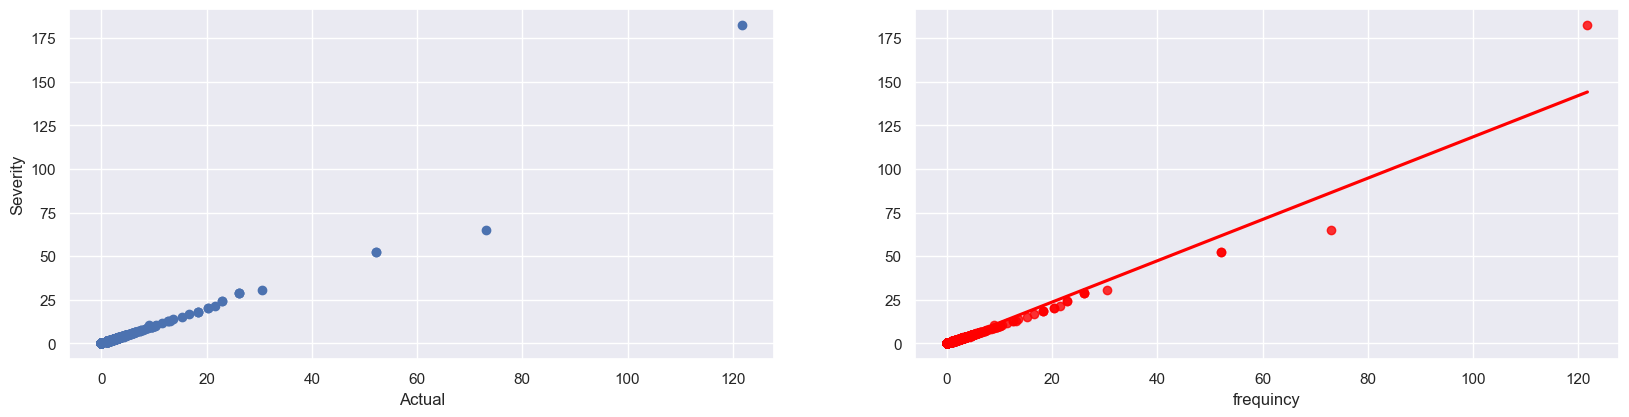

In [17]:
plt.subplot(221)
plt.scatter(ytest,preds);

plt.xlabel('Actual');
plt.ylabel('Severity');

plt.subplot(222)
sns.regplot(x=ytest,y=preds,ci=None,color ='red');

---

In [18]:
import pickle
with open ("Frequency_final_model.pkl","wb") as f:
    pickle.dump(my_pipeline,f)

---